In [1]:
from pyspark.mllib.util import MLUtils
from pyspark.ml.feature import StandardScaler
from pyspark.sql.functions import mean, stddev, col
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.clustering import KMeans
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('CustomerCluster').getOrCreate()

### Read data from previous script

In [3]:
from pyspark.sql import HiveContext
hive_context = HiveContext(sc)

In [4]:
data = hive_context.table("mwehr.processed_customer_dataset")
data.show(5)

+-------+------------+-------------------+-------------------+---------------------+-------------------+-------------------+--------------------+--------------------+--------------------+-------------------+--------------------+-------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+---------------+------------------+------------------+
|Cust_Id|total_movies|   top_actor_movies|top_director_movies|total_adultage_movies|total_action_movies| total_scifi_movies|total_history_movies|total_musical_movies|total_romance_movies| total_drama_movies|   total_noir_movies|total_comedy_movies|avg_overall_rating| avg_action_rating|  avg_scifi_rating|avg_history_rating|avg_musical_rating|avg_romance_rating|  avg_drama_rating|avg_noir_rating| avg_comedy_rating|       avg_runtime|
+-------+------------+-------------------+-------------------+---------------------+-------------------+-------------------+----

In [5]:
data.printSchema()

root
 |-- Cust_Id: integer (nullable = true)
 |-- total_movies: long (nullable = true)
 |-- top_actor_movies: double (nullable = true)
 |-- top_director_movies: double (nullable = true)
 |-- total_adultage_movies: double (nullable = true)
 |-- total_action_movies: double (nullable = true)
 |-- total_scifi_movies: double (nullable = true)
 |-- total_history_movies: double (nullable = true)
 |-- total_musical_movies: double (nullable = true)
 |-- total_romance_movies: double (nullable = true)
 |-- total_drama_movies: double (nullable = true)
 |-- total_noir_movies: double (nullable = true)
 |-- total_comedy_movies: double (nullable = true)
 |-- avg_overall_rating: double (nullable = true)
 |-- avg_action_rating: double (nullable = true)
 |-- avg_scifi_rating: double (nullable = true)
 |-- avg_history_rating: double (nullable = true)
 |-- avg_musical_rating: double (nullable = true)
 |-- avg_romance_rating: double (nullable = true)
 |-- avg_drama_rating: double (nullable = true)
 |-- avg_

### Scale columns

Drop all na values

In [6]:
data = data.na.drop()

Select columns that are relevant for clustering

In [7]:
FEATURES_COL = data.columns[1::]

Convert to float (needed to make it readable for KMeans)

In [8]:
for col in data.columns:
    if col in FEATURES_COL:
        data = data.withColumn(col,data[col].cast('float'))

Save all features in one vector. In this way KMeans for pyspark is different from sklearn, as it only takes a vector of features as input, not multiple columns

In [9]:
vecAssembler = VectorAssembler(inputCols=FEATURES_COL, outputCol="features", handleInvalid="keep")
df_kmeans = vecAssembler.transform(data).select("Cust_Id", "features")

Finally, scaling vectorized columns

In [10]:
scaler = StandardScaler(inputCol="features", outputCol="scaled_features", withStd=True, withMean=False)

In [11]:
# Compute summary statistics by fitting the StandardScaler
scalerModel = scaler.fit(df_kmeans)

In [12]:
# Normalize each feature to have unit standard deviation.
df_kmeans = scalerModel.transform(df_kmeans)

### Select optimal k value

Calculating the cost function for different values of k

In [13]:
cost = np.zeros(10)
for k in range(2,10):
    kmeans = KMeans().setK(k).setSeed(1).setFeaturesCol("scaled_features").setPredictionCol("cluster")
    model = kmeans.fit(df_kmeans.sample(False,0.1, seed=42))
    cost[k] = model.computeCost(df_kmeans)

Plotting the results and look for the "elbow" in the cost function

Text(0,0.5,'cost')

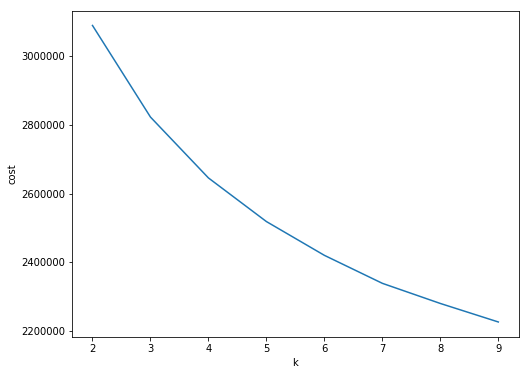

In [14]:
fig, ax = plt.subplots(1,1, figsize =(8,6))
ax.plot(range(2,10),cost[2:10])
ax.set_xlabel('k')
ax.set_ylabel('cost')

It seems like k=4 would a good choice, since the gain after that is less steep but it is still a manageable size

### Running KMeans

Apply KMeans algorithm to the vectorized dataframe and return cluster centers

In [15]:
k = 6
kmeans = KMeans().setK(k).setSeed(1).setFeaturesCol("scaled_features")
model = kmeans.fit(df_kmeans)
centers = model.clusterCenters()

Transform model and return dataframe that that has customer id and cluster

In [16]:
transformed = model.transform(df_kmeans).select("Cust_Id", "prediction")
rows = transformed.collect()

In [17]:
df_pred = sqlContext.createDataFrame(rows)
df_pred.show()

+-------+----------+
|Cust_Id|prediction|
+-------+----------+
|  66871|         4|
|2244834|         4|
|1781728|         1|
|   8158|         3|
|2314776|         4|
| 804617|         4|
|1264196|         2|
|2148279|         3|
| 458697|         3|
|2604811|         3|
|1683479|         1|
|1474256|         3|
| 333069|         4|
| 443828|         2|
|2360740|         1|
|  32346|         5|
|1000192|         5|
|1894937|         1|
|1742099|         4|
|1066801|         2|
+-------+----------+
only showing top 20 rows



Rename prediction column to "cluster"

In [25]:
df_pred = df_pred.withColumnRenamed("prediction", "cluster")

### Save table in contributor's directions

In [28]:
df_pred.write.saveAsTable("akarshsahu.clustered_customer")
df_pred.write.saveAsTable("aghose.clustered_customer")
df_pred.write.saveAsTable("mwehr.clustered_customer")